In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

DATASET_DIR = "dataset"
SAVE_PATH = "best_model_2.pth"
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASSES = "ABEKMHOPCTYX0123456789"
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {char: idx for idx, char in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: char for char, idx in CLASS_TO_IDX.items()}

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Определение модели
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Увеличиваем количество фильтров
            nn.LeakyReLU(negative_slope=0.1),  # Используем LeakyReLU вместо ReLU
            nn.BatchNorm2d(32),  # Нормализация
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),  # Используем ELU вместо ReLU
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),  # Используем SiLU (Swish) вместо ReLU
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.GELU(),  # Используем GELU для полносвязного слоя
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Создание модели и загрузка весов
model = SimpleCNN(len(CLASSES)).to(DEVICE)

# Загрузка весов модели
model.load_state_dict(torch.load("best_model_2.pth", map_location=DEVICE))
print("Weights loaded successfully from best_model_2.pth")

# Перевод модели в режим оценки
model.eval()
print("Model set to evaluation mode")


Weights loaded successfully from best_model_2.pth
Model set to evaluation mode


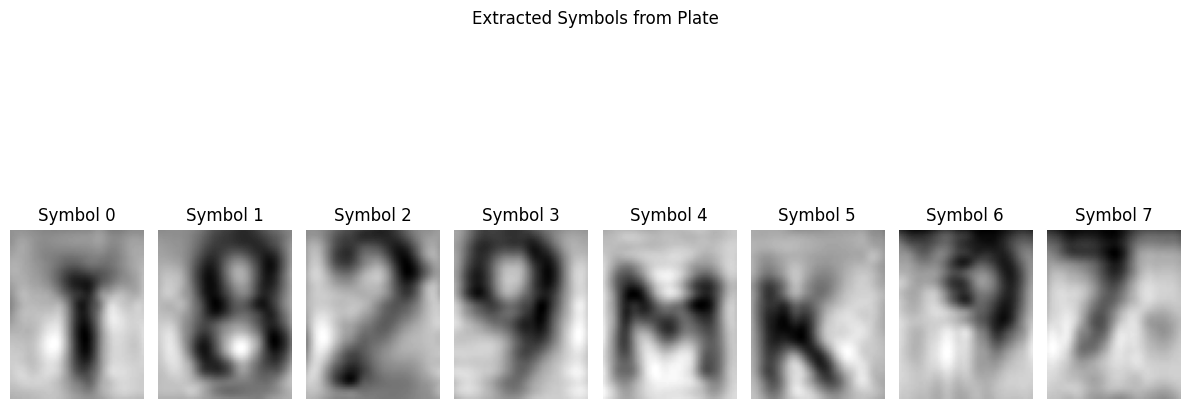

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка изображения в чёрно-белом формате
rotated = cv2.imread("img/plate-viva.jpg", cv2.IMREAD_GRAYSCALE)

# Увеличиваем изображение для лучшей обработки
resized = cv2.resize(rotated, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
img_conf = cv2.GaussianBlur(resized, (3, 3), 0)

# Настройки вырезания
start_x = 25  # начальная координата X
start_y = 25  # начальная координата Y
symbol_width = 55  # базовая ширина символа
symbol_height = 110  # высота символа
spacing = 0  # промежуток между символами

# Настройки для регулировки ширины и высоты
left_adjustment = 4    # Сдвиг с левой стороны (уменьшение ширины: отрицательное, увеличение: положительное)
right_adjustment = 4   # Сдвиг с правой стороны (уменьшение ширины: отрицательное, увеличение: положительное)
top_adjustment = 10    # Сдвиг сверху (уменьшение высоты: отрицательное, увеличение: положительное)
bottom_adjustment = -30  # Сдвиг снизу (уменьшение высоты: отрицательное, увеличение: положительное)

# Последовательность символов на номерном знаке: 1 буква, 3 цифры, 2 буквы, 2 цифры
symbol_sequence = ['буква', 'цифра', 'цифра', 'цифра', 'буква', 'буква', 'цифра', 'цифра']

# Список для сохранения вырезанных символов
chars1 = []

# Вырезаем каждый символ
for i, symbol_type in enumerate(symbol_sequence):
    # Координаты текущего символа с учетом регулировки ширины и высоты
    crop_start_x = start_x + i * (symbol_width + spacing) + left_adjustment
    crop_end_x = start_x + i * (symbol_width + spacing) + symbol_width + right_adjustment

    # Если это последние 2 цифры, поднимаем их выше
    if i >= len(symbol_sequence) - 2:  # Последние два символа
        crop_start_y = start_y + top_adjustment - 11  # Поднимаем символ выше на 10 пикселей
        crop_end_y = start_y + symbol_height + bottom_adjustment - 11
        crop_start_x -=5
        crop_end_x -=5
    else:
        crop_start_y = start_y + top_adjustment
        crop_end_y = start_y + symbol_height + bottom_adjustment

    # Проверяем, что координаты в пределах изображения
    crop_start_x = max(0, crop_start_x)
    crop_end_x = min(img_conf.shape[1], crop_end_x)
    crop_start_y = max(0, crop_start_y)
    crop_end_y = min(img_conf.shape[0], crop_end_y)

    # Вырезаем символ
    crop = img_conf[crop_start_y:crop_end_y, crop_start_x:crop_end_x]

    # Добавляем символ в список
    chars1.append(crop)

# Отображаем все символы с помощью matplotlib
plt.figure(figsize=(12, 6))
for i, char in enumerate(chars1):
    plt.subplot(1, len(chars1), i + 1)  # Создаем сетку для отображения символов
    plt.imshow(char, cmap='gray')
    plt.title(f"Symbol {i}")
    plt.axis('off')

plt.suptitle("Extracted Symbols from Plate")
plt.tight_layout()
plt.show()

# Теперь все символы находятся в списке `chars1`


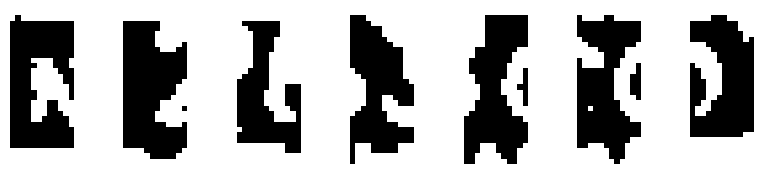

In [37]:
import cv2
import matplotlib.pyplot as plt

# Загрузка изображения номерного знака
image_path = "img/plate3_original.jpg"  # Замените на путь к вашему изображению
plate_image = cv2.imread(image_path)

# Преобразование в оттенки серого
gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

# Бинаризация изображения
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Определение размеров изображения
height, width = binary.shape

# Предполагаемые ширины символов (в процентах от ширины изображения)
symbol_widths = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]  # 7 символов

# Предполагаемые отступы между символами (в процентах от ширины изображения)
symbol_gaps = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02]  # 6 промежутков

# Вычисление абсолютных позиций символов
positions = []
current_x = 0
for i in range(len(symbol_widths)):
    symbol_w = int(symbol_widths[i] * width)
    positions.append((current_x, current_x + symbol_w))
    current_x += symbol_w
    if i < len(symbol_gaps):
        current_x += int(symbol_gaps[i] * width)

# Извлечение и отображение каждого символа
plt.figure(figsize=(10, 2))
for idx, (start_x, end_x) in enumerate(positions):
    symbol = binary[:, start_x:end_x]
    plt.subplot(1, len(positions), idx + 1)
    plt.imshow(symbol, cmap='gray')
    plt.axis('off')
plt.show()


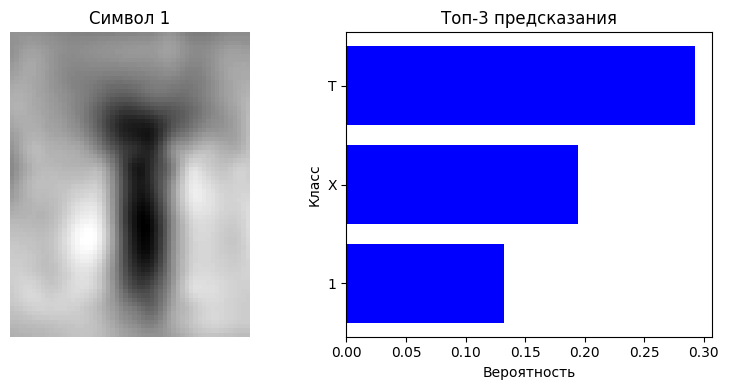

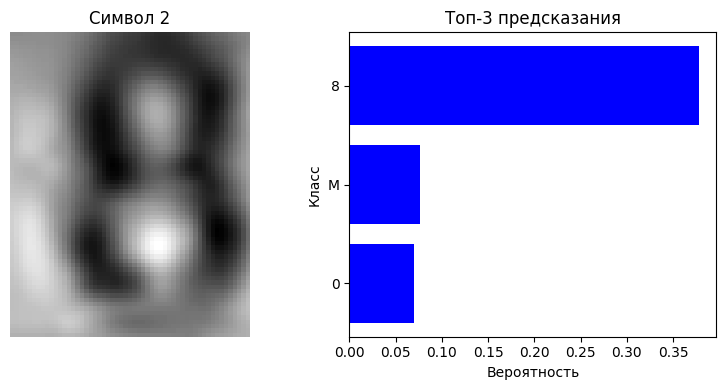

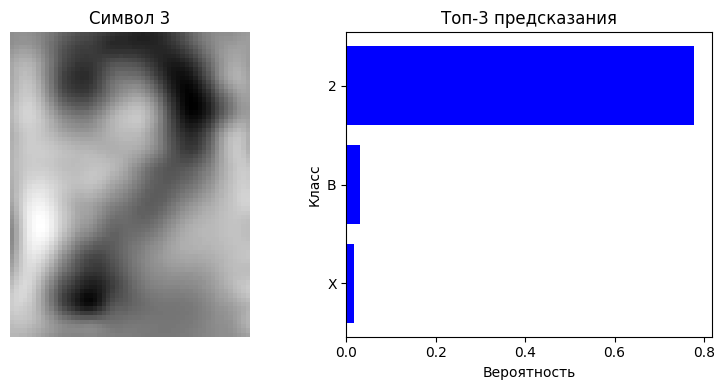

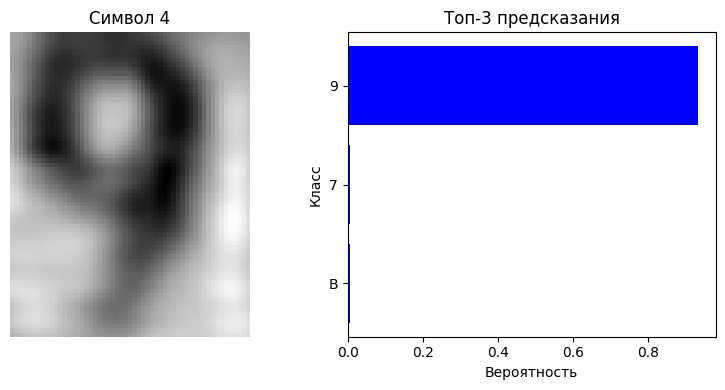

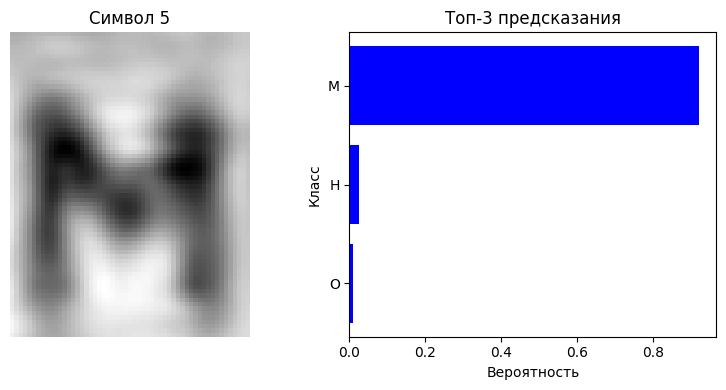

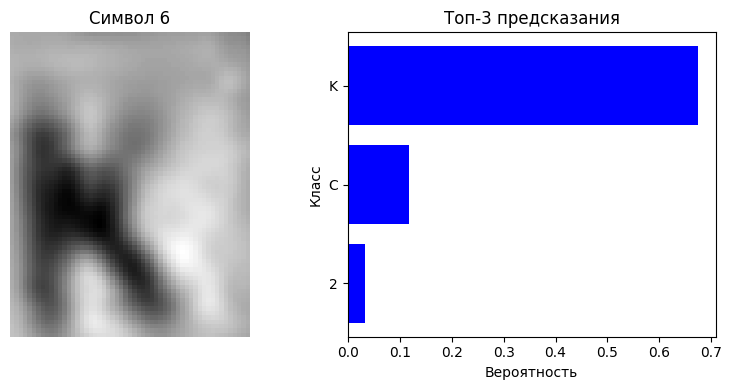

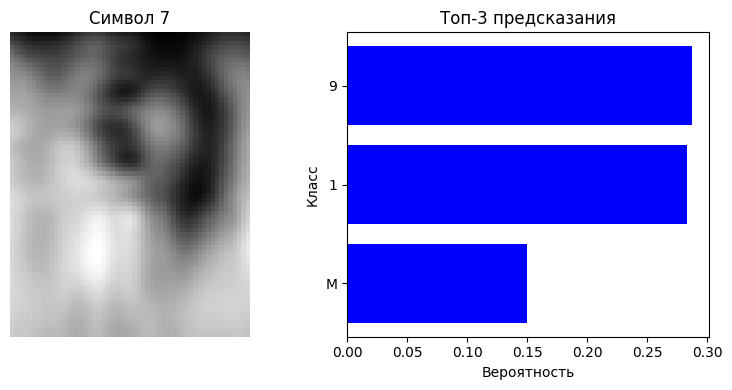

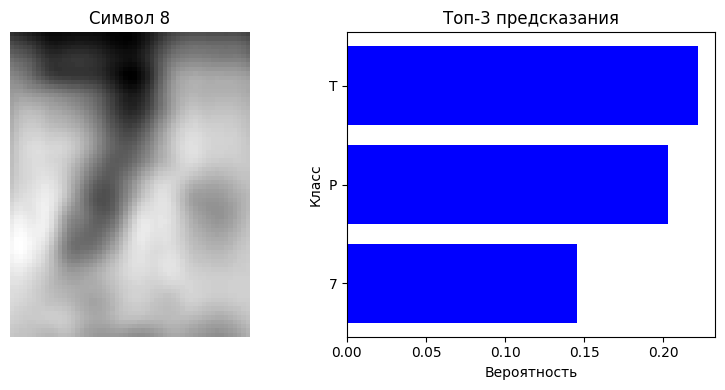

In [27]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
        transforms.Resize((28, 28)),  # Изменяем размер до 28x28
        transforms.ToTensor(), 
        transforms.ColorJitter(brightness=0.5),      # Преобразуем в тензор
        transforms.Normalize(mean=[0.5], std=[0.5])  # Нормализация: среднее 0.5, стандартное отклонение 0.5
    ])

# Функция для получения топ-3 предсказаний
def get_top_predictions(output, top_k=3):
    probabilities = torch.softmax(output, dim=1).squeeze()  # Преобразование в вероятности
    top_probs, top_indices = torch.topk(probabilities, top_k)
    return top_probs.tolist(), [CLASSES[idx] for idx in top_indices.tolist()]

from PIL import Image

# Функция распознавания символов с выводом графиков
def recognize_and_plot_characters(characters, model, device="cpu"):
    """
    Распознает символы из списка изображений characters и строит графики топ-3 предсказаний.

    :param characters: Список символов (массивы numpy 28x28).
    :param model: Загруженная модель для распознавания.
    :param device: Устройство для вычислений ("cpu" или "cuda").
    """
    for i, char in enumerate(characters):
        # Преобразование символа в объект PIL.Image
        char_image = Image.fromarray(char)
        
        # Преобразование символа в тензор
        char_tensor = transform(char_image).unsqueeze(0).to(device)  # Добавляем batch размерности
        
        # Прогон через модель
        with torch.no_grad():
            output = model(char_tensor)
            top_probs, top_classes = get_top_predictions(output)

        # Вывод символа и графика топ-3 предсказаний
        plt.figure(figsize=(8, 4))

        # Символ
        plt.subplot(1, 2, 1)
        plt.imshow(char, cmap='gray')
        plt.axis('off')
        plt.title(f"Символ {i + 1}")

        # Топ-3 предсказания
        plt.subplot(1, 2, 2)
        plt.barh(top_classes, top_probs, color='blue')
        plt.xlabel("Вероятность")
        plt.ylabel("Класс")
        plt.title("Топ-3 предсказания")
        plt.gca().invert_yaxis()  # Инвертируем ось, чтобы лучший класс был сверху

        plt.tight_layout()
        plt.show()


# Использование функции
if len(chars1) > 0:
    recognize_and_plot_characters(chars1, model, device=DEVICE)
else:
    print("Список characters пуст.")


In [13]:
chars1[0]

array([[156, 157, 157, ..., 153, 153, 153],
       [156, 157, 158, ..., 155, 155, 155],
       [156, 157, 158, ..., 158, 157, 157],
       ...,
       [174, 174, 175, ..., 183, 183, 183],
       [172, 173, 174, ..., 180, 180, 180],
       [171, 172, 172, ..., 177, 177, 177]], dtype=uint8)